## Sentiment feature and analysis

https://towardsdatascience.com/sentiment-analysis-for-text-with-deep-learning-2f0a0c6472b5

Model provides a sentiment score between 0 to 1 with 0 being very negative and 1 being very positive. This was done by building a multi-class classification model i.e 10 class, one class for each decile.

Layer 1: An embedding layer of a vector size of 100 and a max length of each sentence is set to 56.
Layer 2: 128 cell bi-directional LSTM layers, where the embedding data is fed to the network. We add a dropout of 0.2 this is used to prevent overfitting.
Layer 3: A 512 layer dense network which takes in the input from the LSTM layer. A Dropout of 0.5 is added here.
Layer 4: A 10 layer dense network with softmax activation, each class is used to represent a sentiment category, with class 1 representing sentiment score between 0.0 to 0.1 and class 10 representing a sentiment score between 0.9 to 1.

Model Parameters:
Activation Function: I have used ReLU as the activation function. ReLU is a non-linear activation function, which helps complex relationships in the data to be captured by the model.
Optimiser: We use adam optimiser, which is an adaptive learning rate optimiser.
Loss function: We will train a network to output a probability over the 10 classes using Cross-Entropy loss, also called Softmax Loss. It is very useful for multi-class classification.

Limitation: only looks at the first 250 chars of meme text

In [1]:
import pandas as pd
import numpy as np

dank_data = pd.read_json(r"C:\Users\HSDSLab-admin\Documents\data\nyt_preprocessed_2018_100_1000.json")
print(len(dank_data))
dank_data.head()

258083


,level_0,index,web_url,uri,date,keywords,all_text,processed,stemmed,lda
0,0,296106,https://www.nytimes.com/2017/12/31/opinion/tom...,nyt://article/4d6e855f-8b4c-550c-b095-0e5e29ea...,2018-01-01,"[Health Insurance and Managed Care, Immigratio...",American health care is a universe of scientif...,"[american, health, care, universe, scientific,...","[american, health, care, univers, scientif, ge...","[american, health, care, univers, scientif, ge..."
1,1,296107,https://www.nytimes.com/2017/12/31/world/ameri...,nyt://article/e8919280-595f-5bb5-882d-ceee0774...,2018-01-01,"[Aviation Accidents, Safety and Disasters, Cos...",The Costa Rican government said the crash occu...,"[costa, rican, government, said, crash, occurr...","[costa, rican, govern, said, crash, occur, mou...","[costa, rican, govern, said, crash, occur, mou..."
2,2,296108,https://www.nytimes.com/2017/12/31/nyregion/me...,nyt://article/07a46192-a0f6-5090-b6da-7e5c6b49...,2018-01-01,"[Metropolitan Detention Center (Brooklyn, NY),...",Families have turned the side of a warehouse f...,"[family, turned, side, warehouse, facing, fede...","[famili, turn, side, warehous, face, feder, ja...","[famili, turn, side, warehous, face, feder, ja..."
3,3,296109,https://www.nytimes.com/2017/12/31/opinion/new...,nyt://article/d8364ef4-cf4d-5c45-97c5-12344a22...,2018-01-01,"[Books and Literature, New Year, Dying: A Memo...",Making New Year resolutions as a hedge against...,"[making, year, resolution, hedge, apocalypse, ...","[make, year, resolut, hedg, apocalyps, make, y...","[make, year, resolut, hedg, apocalyps, make, y..."
4,4,296110,https://www.nytimes.com/2017/12/31/opinion/men...,nyt://article/498926b8-494d-5dd6-873a-6fba4509...,2018-01-01,"[Movies, Hayek, Salma, Women and Girls, Women'...",Screenwriters need to stop letting male charac...,"[screenwriter, need, stop, letting, male, char...","[screenwrit, need, stop, let, male, charact, c...","[screenwrit, need, stop, let, male, charact, c..."


In [2]:
# remove rows with no text (give them a neutral sentiment score 0.5?)

In [3]:
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
#from keras.layers.embeddings import Embedding
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.models import model_from_json
from keras.models import load_model
import h5py
from keras.models import model_from_json
from keras.models import load_model
from flask import Flask, url_for, request
import json
from nltk.tokenize import RegexpTokenizer

In [4]:
# load saved LSTM model
from numpy import loadtxt
from keras.models import load_model
 
# load model
LSTM_model = load_model('sentiment_model.hdf5')
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 56, 100)           40000100  
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 40,371,310
Trainable params: 371,210
Non-trainable params: 40,000,100
______________________________________

In [5]:
def live_analyses(trained_model, data, word_idx):
    live_list = []
    live_list_np = np.zeros((56,1))
    # split the sentence into its words and remove any punctuations.
    tokenizer = RegexpTokenizer(r'\w+')
    data_sample_list = tokenizer.tokenize(data)
    labels = np.array(['1','2','3','4','5','6','7','8','9','10'], dtype = "int")
    # get index for the live stage
    data_index = np.array([word_idx[word.lower()] if word.lower() in word_idx else 0 for word in data_sample_list])
    data_index_np = np.array(data_index)
    # padded with zeros of length 56 i.e maximum length
    padded_array = np.zeros(56)
    padded_array[:data_index_np.shape[0]] = data_index_np
    data_index_np_pad = padded_array.astype(int)
    live_list.append(data_index_np_pad)
    live_list_np = np.asarray(live_list)
    # get score from the model
    score = trained_model.predict(live_list_np, batch_size=1, verbose=0)
    single_score = np.round(np.argmax(score)/10, decimals=2) # maximum of the array i.e single band
    # weighted score of top 3 bands
    top_3_index = np.argsort(score)[0][-3:]
    top_3_scores = score[0][top_3_index]
    top_3_weights = top_3_scores/np.sum(top_3_scores)
    single_score_dot = np.round(np.dot(top_3_index, top_3_weights)/10, decimals = 2)
    return single_score_dot, single_score

In [6]:
import json

word_idx = json.load(open("word_idx.txt"))

In [7]:
from tqdm import tqdm

dank_data['Text'] = 'Empty'
dank_data['Sentiment'] = 2
for ind in tqdm(dank_data.index):
        list_word = dank_data['processed'][ind]
        MemeStr = ' '.join(list_word)
        dank_data['Text'][ind] = MemeStr
        MemeStr = MemeStr[:0]
dank_data.tail()

  0%|                                                                                       | 0/258083 [00:00<?, ?it/s]C:\Users\HSDSLab-admin\AppData\Local\Temp\ipykernel_3840\3683896835.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dank_data['Text'][ind] = MemeStr
100%|████████████████████████████████████████████████████████████████████████| 258083/258083 [01:17<00:00, 3334.56it/s]


,level_0,index,web_url,uri,date,keywords,all_text,processed,stemmed,lda,Text,Sentiment
258078,258078,560528,https://www.nytimes.com/2022/11/14/world/middl...,nyt://article/db7f36b7-dd71-5fde-947f-68373774...,2022-11-14,"[News and News Media, Deaths (Fatalities), Pal...",The Justice Department inquiry is a shift by t...,"[justice, department, inquiry, shift, biden, a...","[justic, depart, inquiri, shift, biden, admini...","[justic, depart, inquiri, shift, biden, admini...",justice department inquiry shift biden adminis...,2
258079,258079,560529,https://www.nytimes.com/2022/11/14/business/me...,nyt://article/321a9558-ccd4-5376-b48f-8963edac...,2022-11-14,"[News and News Media, Radio, Newspapers, Bosto...","Ms. Barnes, senior vice president for news and...","[barnes, senior, vice, president, news, editor...","[barn, senior, vice, presid, news, editori, di...","[barn, senior, vice, presid, news, editori, di...",barnes senior vice president news editorial di...,2
258080,258080,560530,https://www.nytimes.com/2022/11/14/business/tr...,nyt://article/b6af069a-3b27-5ec4-8a39-264fb3da...,2022-11-14,"[AIRLINES AND AIRPLANES, Fines (Penalties), Co...",The Transportation Department penalties come a...,"[transportation, department, penalty, come, ma...","[transport, depart, penalti, come, mani, trave...","[transport, depart, penalti, come, mani, trave...",transportation department penalty come many tr...,2
258081,258081,560531,https://www.nytimes.com/2022/11/14/sports/olym...,nyt://article/2b6f1b2e-6882-5709-81f5-97e0fb86...,2022-11-14,"[Sex Crimes, Abuse of the Disabled, Suits and ...","Parker Egbert, 19, said in a lawsuit that he w...","[parker, egbert, said, lawsuit, repeatedly, as...","[parker, egbert, said, lawsuit, repeatedli, as...","[parker, egbert, said, lawsuit, repeatedli, as...",parker egbert said lawsuit repeatedly assaulte...,2
258082,258082,560532,https://www.nytimes.com/2022/11/14/technology/...,nyt://article/858fef40-a53d-55ca-85b9-48c2140a...,2022-11-14,"[Midterm Elections (2022), Conspiracy Theories...",False narratives failed to take root on Electi...,"[false, narrative, failed, take, root, electio...","[fals, narr, fail, take, root, elect, sever, r...","[fals, narr, fail, take, root, elect, sever, r...",false narrative failed take root election seve...,2


In [8]:
from tqdm import tqdm

for ind in range(0,len(dank_data)):
        #list_word = dank_data['processed_words'][ind]
        MemeStr = dank_data['Text'][ind]
        if len(MemeStr) > 250:
            MemeStr = MemeStr[:250] 
        #result = live_analyses(LSTM_model,' '.join(list_word), word_idx)
        result = live_analyses(LSTM_model,MemeStr, word_idx)
        MemeStr = MemeStr[:0]
        sentiment = np.array(result)
        dank_data['Sentiment'][ind] = sentiment[1]
        if ind % 10000 == 0: # save progress every 10000 rows
            save = dank_data[ind-10000:ind]
            save = save[['uri','Sentiment']]
            save.to_json('sentiment_'+str(ind)+'.json')
        if ind == len(dank_data)-1:
            print('hello')
            save = dank_data[ind-10000:ind]
            save = save[['uri','Sentiment']]
            save.to_json('sentiment_'+str(ind)+'.json')
        ind+=1
        #MemeStr
        #for words in list_word:
            #text = text + ' ' + words
            #if len(text) > 300:
                #text = text[:300] 
                 #result = live_analyses(LSTM_model,text, word_idx)
                 #batch_data['sentiment'] = result  
            #data.append(live_analyses(LSTM_model,text, word_idx))

C:\Users\HSDSLab-admin\AppData\Local\Temp\ipykernel_3840\3942742015.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dank_data['Sentiment'][ind] = sentiment[1]


hello


## Merge together processed files

In [37]:
check = pd.read_json('sentiment_112000.json')
print(len(check))
check1 = pd.read_json('sentiment_120000.json')
print(len(check1))
print(len(check)+len(check1))
alldf = pd.concat([check,check1])
print(len(alldf))

112000
10000
122000
122000


In [48]:
alldf.drop_duplicates(subset=['id'],inplace=True)
len(alldf)

899765

In [49]:
alldf.to_json('sentiment.json')

In [34]:
check1.head()

,id,Sentiment
120000,2019.01.23_410,0.4
120001,2022.03.02_374,0.5
120002,2020.06.20_130,0.5
120003,2018.09.28_912,0.5
120004,2018.10.16_202,0.5


### A little analysis

In [4]:
import pandas as pd

sentiment_df = pd.read_json('../results/processed_features/sentiment_memes.json')
meme_df = pd.read_json('../../data/memesfinal.json')
meme_df = meme_df[['id','score']]
df = meme_df.merge(sentiment_df,on='id')
df.head()

,id,score,Sentiment
0,2021.02.15_288,211152,0.3
1,2020.10.20_959,207206,0.0
2,2020.01.18_675,207066,0.5
3,2020.06.09_755,187936,0.1
4,2020.07.08_336,182056,0.5


Text(0.5, 1.0, 'sentiment scores: most memes are neutral, 0.5')

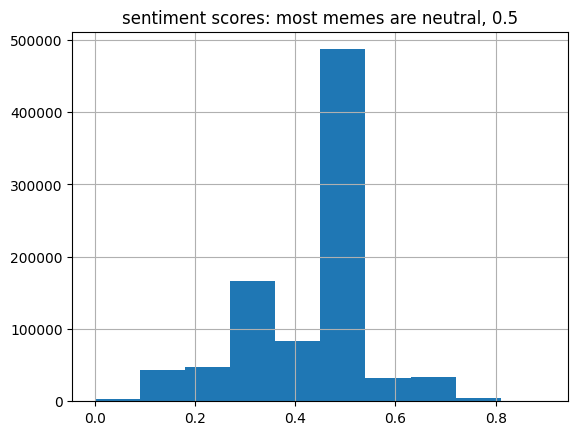

In [15]:
df['Sentiment'].hist(bins=10)
plt.title('sentiment scores: most memes are neutral, 0.5')